In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sea
from scipy.stats import mannwhitneyu, skew, ttest_ind
import networkx as nx
from sklearn.mixture import GaussianMixture

In [2]:
%matplotlib inline

# Task 1 - Bike journey data

In [3]:
bike = pd.read_csv("metro.csv")
bike.shape

(95283, 14)

In [4]:
#Identify null and empty values

null_columns=bike.columns[bike.isnull().any()]

#print(bike[null_columns].isnull().sum())
nulls = bike[bike.isnull().any(axis=1)][null_columns].head()
print(nulls)

     start_lat   start_lon   end_lat     end_lon
50   34.014309 -118.491341       NaN         NaN
198  34.049889 -118.255882       NaN         NaN
250  34.046070 -118.233093       NaN         NaN
287  34.023392 -118.479637       NaN         NaN
338        NaN         NaN  34.05088 -118.248253


Trips in the matrix - 50, 198, 250 and 287 can be identified as trips were the bike have either, not finished the trip or have not been returned to a station. Therefore it may be wise to drop these from the dataset

In [5]:
print(bike.loc[338])

stations = pd.read_csv("stations.csv")

stations[stations['Region'].isnull()]

trip_id                           94952010
duration                                23
start_time             2018-07-01 14:44:00
end_time               2018-07-01 15:07:00
start_station                         3000
start_lat                              NaN
start_lon                              NaN
end_station                           3069
end_lat                            34.0509
end_lon                           -118.248
bike_id                              12100
plan_duration                            1
trip_route_category                One Way
passholder_type               One Day Pass
Name: 338, dtype: object


,Station_ID,Station_Name,Go_live_date,Region,Status
0,3000,Virtual Station,2016-07-07,NaN,Active


In [6]:
# Output from bikes.csv
# Check for lon lat in all entries to identify that it is the only one
bike[bike['start_lat'].isnull() | bike['end_lat'].isnull() | bike['start_lon'].isnull() | bike['end_lon'].isnull()][['start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon']]

,start_station,start_lat,start_lon,end_station,end_lat,end_lon
50,4215,34.014309,-118.491341,3000,NaN,NaN
198,3032,34.049889,-118.255882,3000,NaN,NaN
250,3022,34.046070,-118.233093,3000,NaN,NaN
287,4216,34.023392,-118.479637,3000,NaN,NaN
338,3000,NaN,NaN,3069,34.050880,-118.248253
340,3000,NaN,NaN,3069,34.050880,-118.248253
341,4207,34.000881,-118.468910,3000,NaN,NaN
350,3000,NaN,NaN,3032,34.049889,-118.255882
428,3079,34.050140,-118.233238,3000,NaN,NaN
452,3058,34.035801,-118.233170,3000,NaN,NaN


As shown above Station 3000 is the only station to only have a missing Lon and Lat, and as stated by the metro website where the dataset can be obtained, station 3000 is stated to be a "Virtual Station". Therefore dropping this station from the dataset as it contains non-standard values

In [7]:
bike_cleaned = bike.dropna(how='any',axis=0)

In [8]:
bike_cleaned.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,9.319900e+04,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000,93199.000000
mean,1.020450e+08,39.150903,3453.815921,34.031744,-118.297169,3454.848282,34.031997,-118.297607,8329.991781,22.573000
std,3.391003e+06,106.635812,555.496890,0.064308,0.102349,556.044923,0.063870,0.103344,2889.897390,51.592113
min,9.485113e+07,1.000000,3005.000000,33.710979,-118.491341,3005.000000,33.710979,-118.491341,4727.000000,1.000000
25%,9.919732e+07,7.000000,3030.000000,34.014309,-118.282722,3031.000000,34.014309,-118.283409,6087.000000,1.000000
50%,1.033932e+08,14.000000,3064.000000,34.045422,-118.256187,3064.000000,34.045181,-118.256187,6484.000000,30.000000
75%,1.048693e+08,33.000000,4204.000000,34.050880,-118.243530,4204.000000,34.049889,-118.243530,12110.000000,30.000000
max,1.065433e+08,1440.000000,4267.000000,34.165291,-118.116539,4267.000000,34.165291,-118.116539,12456.000000,365.000000


In [9]:
bike_cleaned['passholder_type'].describe()

count       93199
unique          5
top       Walk-up
freq        44076
Name: passholder_type, dtype: object

In [10]:
bike_cleaned['trip_route_category'].describe()

count       93199
unique          2
top       One Way
freq        74986
Name: trip_route_category, dtype: object

From these basic statistics we can identify that the most popular passholder type is 'Walk-up' and people generally only go on One way trips

## Duration statistics

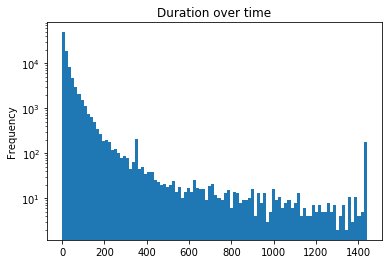

In [11]:
bike_cleaned['duration'].plot.hist(bins=100, logy=True, title='Duration over time')

#### Stats of the duration column

In [12]:
print('Mean')
print(bike_cleaned['duration'].mean())
print('Median')
print(bike_cleaned['duration'].median())
print('Standard Deviation')
print(np.std(bike_cleaned['duration']))
print('Variance')
print(np.var(bike_cleaned['duration']))

Mean
39.15090290668355
Median
14.0
Standard Deviation
106.63523998879094
Variance
11371.07440746704


In [13]:
bike_cleaned['duration'].describe()

count    93199.000000
mean        39.150903
std        106.635812
min          1.000000
25%          7.000000
50%         14.000000
75%         33.000000
max       1440.000000
Name: duration, dtype: float64

In [14]:
print(bike_cleaned['passholder_type'].value_counts(), '\n\n', 'Frequency: \n', bike_cleaned['passholder_type'].value_counts(normalize=True))

Walk-up         44076
Monthly Pass    43102
One Day Pass     4445
Flex Pass        1566
Annual Pass        10
Name: passholder_type, dtype: int64 

 Frequency: 
 Walk-up         0.472924
Monthly Pass    0.462473
One Day Pass    0.047694
Flex Pass       0.016803
Annual Pass     0.000107
Name: passholder_type, dtype: float64


##### Station 3000 against duration and effect on data

In [15]:
bike_station_3000 = bike[bike['start_lat'].isnull() | bike['end_lat'].isnull()]

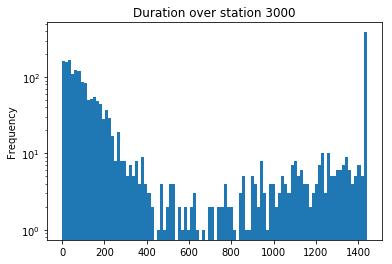

In [16]:
bike_station_3000['duration'].plot.hist(bins=100, logy=True, title='Duration over station 3000')

As the plot shows, the duration data from station 3000 is heavily right skewed and has a high probability to have a max duration above 1400 - described in the statistics below, when comparing the duration of all other stations to station 3000



In [17]:
print(bike_cleaned['duration'].describe(), '\n\n ', bike_station_3000['duration'].describe())

count    93199.000000
mean        39.150903
std        106.635812
min          1.000000
25%          7.000000
50%         14.000000
75%         33.000000
max       1440.000000
Name: duration, dtype: float64 

  count    2084.000000
mean      458.312860
std       570.550371
min         1.000000
25%        49.000000
50%       129.000000
75%      1087.500000
max      1440.000000
Name: duration, dtype: float64


Both count and standard deviation are very different from each other which may suggest that they have different distributions

In [18]:
from scipy.stats import skew
print("Station 3000: ", skew(bike_station_3000['duration']))
print("Bike Cleaned: ", skew(bike_cleaned['duration']))

Station 3000:  0.952220627995309
Bike Cleaned:  8.914564904653744


Station 3000: This shows that the data is positively skewed towards 0, however based on the mean being 458.31 and what the plot shows the data is heavily negatively skewed towards the mean of the data, regardless of the max value of the station
<br>
Bike Cleaned: This shows that the data is positively skewed, but when skewing against the mean of the data it is heavily negatively skewed

Both are different skews which also indicates that they have different distributions

count    93199.000000
mean        39.150903
std        106.635812
min          1.000000
25%          7.000000
50%         14.000000
75%         33.000000
max       1440.000000
Name: duration, dtype: float64


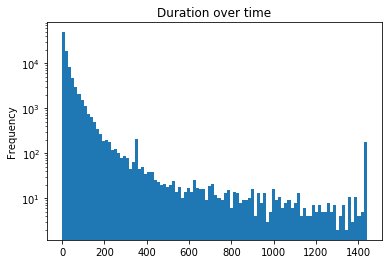

In [19]:
bike_cleaned['duration'].plot.hist(bins=100, logy=True, title='Duration over time')
print(bike_cleaned['duration'].describe())

In [20]:
# Compare the distrubtion type of the two data (NO NEED for P-value as it is not normally distributed) compare variance of data
print('Variance of cleaned bike data:', np.var(bike_cleaned['duration']))
print('Variance of Station 3000 data:', np.var(bike_station_3000['duration']))

Variance of cleaned bike data: 11371.07440746704
Variance of Station 3000 data: 325371.52208030474


##### Comparing Variances

An F-test will be used to compare these based on 121 samples from each dataset, the degrees of freedom will be calculated and the aplha level identified - both for single and two tailed

Null Hypothesis H0: The distributions are the same
<br> 
Alternative Hypothesis H1: They have different distributions

##### F-Test

For this a sample of 121 will be taken from each dataset, due to the variance being considerable in each dataset

In [79]:
bike_cleaned_sample = bike_cleaned.head(121)
bike_3000_sample = bike_station_3000.head(121)

bike_var = np.var(bike_cleaned_sample['duration'])
bike_3000_var = np.var(bike_3000_sample['duration'])
print(bike_var, bike_3000_var)

f_value = np.divide(bike_3000_var, bike_var)
print('F-statistic:', f_value)

55397.24772898026 417037.31821596884
F-statistic: 7.528123423319492


In [80]:
#Degrees of freedom
freedom_3000 = len(bike_cleaned_sample['duration']) - 1
freedom_bike = len(bike_3000_sample['duration']) -1

print(freedom_3000, freedom_bike)

alpha_level = 0.025 # Looking up the f-table for F-statistic 28.61.. Between DF2(3)/DF1(4-5)

# 28.710
print(f_value, '> 1.433 at alpha level 0.025')
print('Therefore the null hypothesis can be rejected for two tailed')
print(f_value, '> 1.3519 at alpha level 0.05')
print('Therefore the null hypothesis can be rejected for single tailed')

120 120
7.528123423319492 > 1.433 at alpha level 0.025
Therefore the null hypothesis can be rejected for two tailed
7.528123423319492 > 1.3519 at alpha level 0.05
Therefore the null hypothesis can be rejected for single tailed


This shows that the null hypthesis does not apply here, and shows that both datasets have different distributions

In [82]:
# P-value: mannwhitneyU test

print("P-Value: ", mannwhitneyu(bike_station_3000['duration'], bike_cleaned['duration']).pvalue)

P-Value:  0.0


##### Assumptions

There is only one dependant variable used in this - duration

An independant variable that is split into, with/without station 3000

The low Pvalue shows that the data is not normally distributed

By adding station 3000 to the data it would skew the data, specifically the duration value and may provide inaccurate results in later analysis

In [25]:
# median and mean
print('Mean')
print(bike_cleaned['duration'].mean())
print('Median')
print(bike_cleaned['duration'].median())

print("")
print("3000 Mean")
print(bike_station_3000['duration'].mean())
print("3000 Median")
print(bike_station_3000['duration'].median())

Mean
39.15090290668355
Median
14.0

3000 Mean
458.3128598848368
3000 Median
129.0


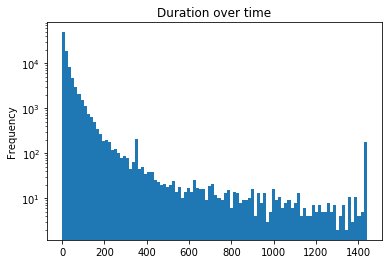

In [26]:
bike_cleaned['duration'].plot.hist(bins=100, logy=True, title='Duration over time')

As shown in the statistics above and the skew of this data, the duration field is positively skewed. Most of the data resides in the 25th percentile, where as fequency of the trips increase the shorter the duration. 
Although there is an unusal value residing at ~1450 which could possibly be an outlier.

What can be observed from this in terms of trip length is that the majority of people are hiring the bikes for short journeys that have a low duration.

The median also shows that the majority of journeys are under 14 minutes and the high sd value shows that the duration is well spread thoughout the dataset

## Comparision of Passholder type against duration

Produce a plot showing how the distribution of duration relates to passholder
type.

In [27]:
print(bike_cleaned['passholder_type'].value_counts(), '\n\n', 'Frequency: \n', bike_cleaned['passholder_type'].value_counts(normalize=True))

Walk-up         44076
Monthly Pass    43102
One Day Pass     4445
Flex Pass        1566
Annual Pass        10
Name: passholder_type, dtype: int64 

 Frequency: 
 Walk-up         0.472924
Monthly Pass    0.462473
One Day Pass    0.047694
Flex Pass       0.016803
Annual Pass     0.000107
Name: passholder_type, dtype: float64


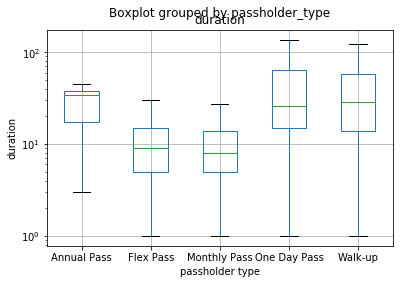

In [28]:
fig, ax = plt.subplots()

bike_cleaned[['passholder_type', 'duration']].boxplot(by='passholder_type', ax=ax, showfliers=False)
ax.set_yscale('log')
plt.ylabel('duration')
plt.xlabel('passholder type');

With Fliers


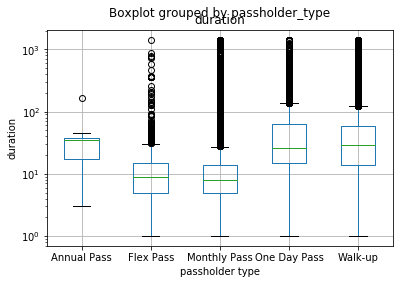

In [29]:
print("With Fliers")
fig, ax = plt.subplots()
bike_cleaned[['passholder_type', 'duration']].boxplot(by='passholder_type', ax=ax, showfliers=True)
ax.set_yscale('log')
plt.ylabel('duration')
plt.xlabel('passholder type');

From both of the box plots, Annual Pass has the least amount of spread/range compared to the other pass type and the smallest range, and has the smallet upper range compared to the others. This may be due to that the holders of this pass may be daily commuters only traveling at a specific time of the day, on specific days, although this is hard to prove from the data shown in the box plots as it doesn't show the sample sizes.

Both one day pass and walk up holders have the highest average duration than that of the other passes, which shows that these could be the most popular passes. While Flex and Monthly pass have the lowest average duration with the lowest range.
This suggests that these are not the most popular passes to use.

- The number of samples in each distribution is different, this is due to each of the pass types having a different number of people with those pass types.


In [30]:
bike_cleaned['passholder_type'].value_counts()

Walk-up         44076
Monthly Pass    43102
One Day Pass     4445
Flex Pass        1566
Annual Pass        10
Name: passholder_type, dtype: int64

## Mean duation between One Day Pass and Flex Pass passholders. 

In [31]:
bike_cleaned

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,94851140,8,2018-07-01 00:04:00,2018-07-01 00:12:00,3058,34.035801,-118.233170,3082,34.046520,-118.237411,6279,30,One Way,Monthly Pass
1,94851141,8,2018-07-01 00:04:00,2018-07-01 00:12:00,3058,34.035801,-118.233170,3082,34.046520,-118.237411,6518,365,One Way,Flex Pass
2,94851138,15,2018-07-01 00:09:00,2018-07-01 00:24:00,4147,34.145248,-118.150070,4174,34.165291,-118.150970,4823,365,One Way,Monthly Pass
3,94851137,7,2018-07-01 00:22:00,2018-07-01 00:29:00,4157,34.140999,-118.132088,4162,34.147499,-118.148010,6115,30,One Way,Monthly Pass
4,94851136,35,2018-07-01 00:23:00,2018-07-01 00:58:00,3013,33.779819,-118.263023,3013,33.779819,-118.263023,12055,1,Round Trip,Walk-up
5,94851135,6,2018-07-01 00:38:00,2018-07-01 00:44:00,3029,34.048851,-118.246422,3082,34.046520,-118.237411,6370,1,One Way,Walk-up
6,94851134,5,2018-07-01 00:39:00,2018-07-01 00:44:00,3029,34.048851,-118.246422,3082,34.046520,-118.237411,6566,1,One Way,Walk-up
7,94857739,33,2018-07-01 00:40:00,2018-07-01 01:13:00,3069,34.050880,-118.248253,3075,34.042110,-118.256187,6407,1,One Way,Walk-up
8,94851133,6,2018-07-01 00:44:00,2018-07-01 00:50:00,3067,34.045181,-118.250237,3062,34.047749,-118.243172,5859,30,One Way,Monthly Pass
9,94851132,3,2018-07-01 00:46:00,2018-07-01 00:49:00,3034,34.042061,-118.263382,3074,34.044170,-118.261169,6562,30,One Way,Monthly Pass


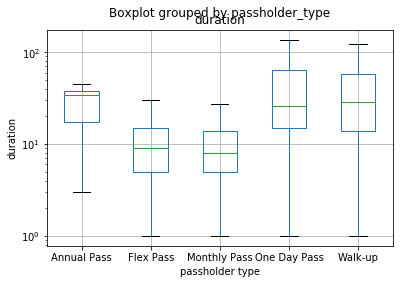

In [32]:
fig, ax = plt.subplots()

bike_cleaned[['passholder_type', 'duration']].boxplot(by='passholder_type', ax=ax, showfliers=False)
ax.set_yscale('log')
plt.ylabel('duration')
plt.xlabel('passholder type');

From the box plot above there is clearly a significant different between the mean average of Flex pass compared to One Day pass types.

Statistical tests will help identify why this is, using a student's T-test and mannwhitneyU test. Although the student's t-test assumes that the variance are the same or similar, but this can change with different sample sizes.

In [83]:
#one_day = bike_cleaned[['passholder_type', 'duration']] == 'One Day Pass'
one_day_pass = bike_cleaned[bike_cleaned['passholder_type'] == 'One Day Pass']
flex_pass = bike_cleaned[bike_cleaned['passholder_type'] == 'Flex Pass']

flex_mean = flex_pass['duration'].mean()
one_day_mean = one_day_pass['duration'].mean()
print("Flex Mean:", flex_mean, "\nOne Day Mean:", one_day_mean)

Flex Mean: 18.56257982120051 
One Day Mean: 66.51878515185602


Text(0, 0.5, 'sample')

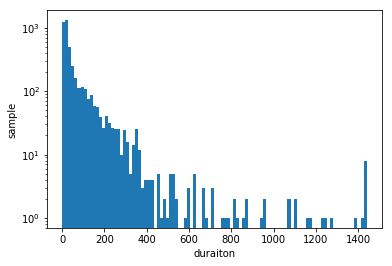

In [84]:
one_day_plot = one_day_pass['duration'].plot.hist(bins=100, logy=True)
one_day_plot.set_xlabel("duraiton")
one_day_plot.set_ylabel("sample")

Text(0, 0.5, 'sample')

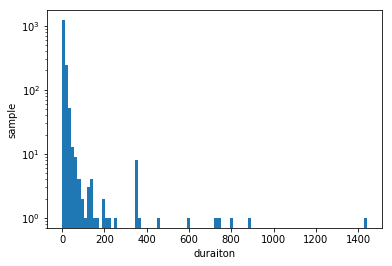

In [85]:
flex_plot = flex_pass['duration'].plot.hist(bins=100, logy=True)
flex_plot.set_xlabel("duraiton")
flex_plot.set_ylabel("sample")

In [36]:
# Sample size difference
sample_sizes = len(one_day_pass), len(flex_pass)
# Variance difference
variances = np.var(one_day_pass['duration']), np.var(flex_pass['duration'])
print("Variances: ", variances, "\nVariance Difference: ", variances[0] - variances[1], "\n\nSample Sizes: ", sample_sizes, "\nSample Difference: ", sample_sizes[0] - sample_sizes[1])

Variances:  (15650.955158929093, 4212.058344302377) 
Variance Difference:  11438.896814626716 

Sample Sizes:  (4445, 1566) 
Sample Difference:  2879


The histograms above show there are differences in the both the variances and sample sizes, but show that both are positively skewed and normally distributed.

As shown the means for either are clearly different, and both the sample size and variance are very different, therefore Student's T-test could not apply here as it is a parametric test and assumes homogeneity of the variance, whereas MannwhitneyU test is non parametric.

Both will be used, but compared by their accuracy of their pvalue to validate the hypothesis'

H0 - Assumes that both distributions have the same means

H1 - Assumes that both distributions have different means


In [37]:
print(mannwhitneyu(one_day_pass['duration'], flex_pass['duration']))
print(ttest_ind(one_day_pass['duration'], flex_pass['duration'], equal_var=True))

MannwhitneyuResult(statistic=1300630.5, pvalue=1.089459637342107e-298)
Ttest_indResult(statistic=14.495319337859621, pvalue=7.9422977182875e-47)


This shows that the original distributions are not noramlly distributed due to the difference in sample sizes, and that the Student's T-Test is not a suitable test. However the MannWhitneyU test, being non parametric, shows that the means are equal. Therefore rejecting the Null Hypothesis and supporting the alternative where the means are unequal.

Additionally the central limit theorm could be used to reduce the number of samples in scale to obtain approximate normal distribution.

##### Central Limit Theorm
The central Limit Theorm could possibly be used in this case to limit/reduce the amount of samples used. This will split the dataframe into a new dataframe / by the sample size (arrays within the dataframe that contain a sample of e.g 150 random samples from the data). The mean for each of the array sets will be made, variances of the dataframe will be calculated and this will then be used in the Student's T-Test and MannwhitneyU Test. However based on assumptions from above, due to the data not being normally distributed student's t-test still wouldn't be a suitable test to be conducted, however mannwhitneyU will return the same conclusion as it is non parametric it disregards the sample size.

### Convert start time and end time to datatime object

In [38]:
pd.options.mode.chained_assignment = None  # Removes warning - https://stackoverflow.com/questions/43367615/dataframe-warning-settingwithcopywarning-in-python

bike_cleaned['start_time'] = pd.to_datetime(bike_cleaned['start_time'], format = '%Y-%m-%d %H:%M:%S')
bike_cleaned['end_time'] = pd.to_datetime(bike_cleaned['end_time'], format = '%Y-%m-%d %H:%M:%S')
print(bike_cleaned.dtypes)

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                         int64
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object


### New hour column

In [39]:
bike_cleaned['start_hour'] = bike_cleaned['start_time'].apply(lambda x: x.hour)
bike_cleaned.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_hour
0,94851140,8,2018-07-01 00:04:00,2018-07-01 00:12:00,3058,34.035801,-118.233170,3082,34.046520,-118.237411,6279,30,One Way,Monthly Pass,0
1,94851141,8,2018-07-01 00:04:00,2018-07-01 00:12:00,3058,34.035801,-118.233170,3082,34.046520,-118.237411,6518,365,One Way,Flex Pass,0
2,94851138,15,2018-07-01 00:09:00,2018-07-01 00:24:00,4147,34.145248,-118.150070,4174,34.165291,-118.150970,4823,365,One Way,Monthly Pass,0
3,94851137,7,2018-07-01 00:22:00,2018-07-01 00:29:00,4157,34.140999,-118.132088,4162,34.147499,-118.148010,6115,30,One Way,Monthly Pass,0
4,94851136,35,2018-07-01 00:23:00,2018-07-01 00:58:00,3013,33.779819,-118.263023,3013,33.779819,-118.263023,12055,1,Round Trip,Walk-up,0


###  Duration variable varies between each journey starting hour of the day

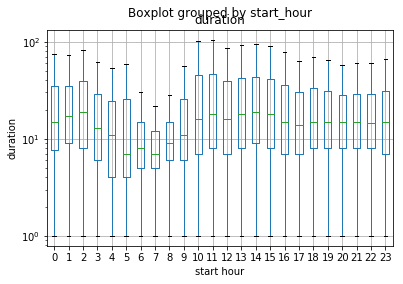

In [40]:
fig, ax = plt.subplots()
bike_cleaned[['start_hour', 'duration']].boxplot(by='start_hour', ax=ax, showfliers=False)
ax.set_yscale('log')
plt.ylabel('duration')
plt.xlabel('start hour');


From the box plot above, from 4am to 10am have the lowest average duration by hour compared to the rest of the times, with 7am being the lowest. This suggests that this is peak travel time where people are either taking shorter trips or are hurrying to work. 

Whereas the times from 16:00 to 19:00 are roughly the same average duration, which would be peak time to travel home from work, however there wouldn't be a rush, which is displayed by the average duration hovering around the median duration. (Eye balled not plotted)

### Distribution of the duration variable varies between each day of the week

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

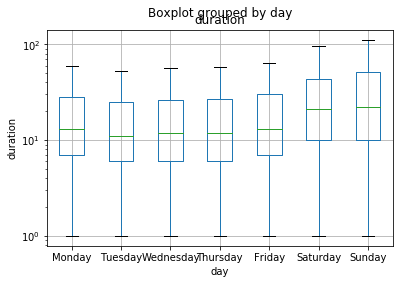

In [41]:
bike_cleaned['day'] = bike_cleaned['start_time'].apply(lambda x: x.weekday())

fig, ax = plt.subplots()
bike_cleaned[['day', 'duration']].boxplot(by='day', ax=ax, showfliers=False)
ax.set_yscale('log')
plt.ylabel('duration')
plt.xlabel('day');
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

The boxplot above shows that there is a clear difference by those traveling on weekends compared to those who travel on the weekdays - the durations of the trips are much longer

Therefore the data was split to analysis, as shown in the two histograms.

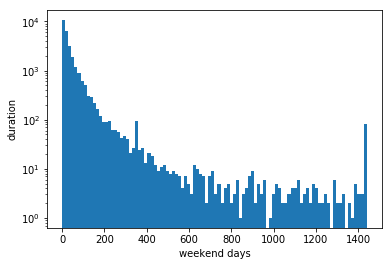

In [42]:
## Check weekends and weekdays as histogram
# 5, 6 = weekends

weekend = bike_cleaned[bike_cleaned['day'] >= 5]
weekend['duration'].plot.hist(log=True, bins=100);
plt.ylabel('duration')
plt.xlabel('weekend days');

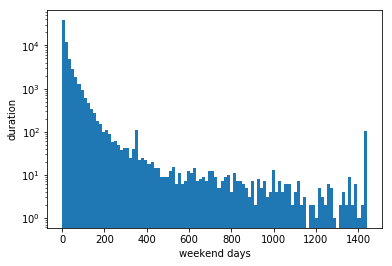

In [43]:
# 0,1,2,3,4 = weekdays

weekday = bike_cleaned[bike_cleaned['day'] <= 4]
weekday['duration'].plot.hist(log=True, bins=100);
plt.ylabel('duration')
plt.xlabel('weekend days');

Although the histograms look almost identical, eyeballing it, the histogram plotting the weekend has more spread towards the upper quartile, 1000-1300 duration, than the weekday plot.

This can further be shown by finding the mean and variances of both dataframes and performing a MannWhitneyU test.

In [44]:
# Get mean and variance of each

weekend_mean = np.mean(bike_cleaned['duration'] >= 5)
weekend_var = np.var(bike_cleaned['duration'] >= 5)
weekday_mean = np.mean(bike_cleaned['duration'] <= 4)
weekday_var = np.var(bike_cleaned['duration'] <= 4)
print("Weekend Mean: ", weekend_mean, "\nWeekend Variance: ", weekend_var)
print("\nWeekday Mean: ", weekday_mean, "\nWeekday Variance: ", weekday_var)

print("\n\n", ttest_ind(weekday['duration'], weekend['duration'], equal_var=True))
print(mannwhitneyu(weekday['duration'], weekend['duration']))

Weekend Mean:  0.8932284681166107 
Weekend Variance:  0.09537137186266369

Weekday Mean:  0.10677153188338931 
Weekday Variance:  0.0953713718626637


 Ttest_indResult(statistic=-25.840310188737195, pvalue=1.0317618797109718e-146)
MannwhitneyuResult(statistic=678518769.0, pvalue=0.0)


This shows that the means of both are different
The p-value of the Student's t-test shows that this isn't a suitable test as it suggests that they are exactly equal and tha the data is perfectly described.
However the p-value from the mannwhitneyU test shows that it is unlikely that the the durations from either come from the same distributions due to rejecting the null hypothesis that they are from the same distribution. 
Additionally this is shown by looking at the means for either, which shows that the weekend has a higher duration mean than the weekdays

### Total numbers of passholders of each type travelling on each week day

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

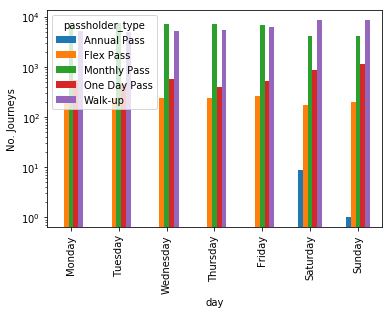

In [45]:
passholder_type_day = bike_cleaned.groupby(['day', 'passholder_type'])['day'].size()

fig, ax = plt.subplots()
passholder_type_day.unstack().plot.bar(by='day', ax=ax)
ax.set_yscale('log')
plt.ylabel('No. Journeys')
plt.xlabel('day');
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

This bar plot shows the total number of passholders of each type that travel on each day of the week.
From this the amount of passholders can be seen for each type and the frequency on each day. Monthly and Walk-up passes being the most popular and having the most number of journeys. 
With Flex and one-day pass holders hovering around the average number of journeys.

Also the number of journeys increase during the weekends.

However, annual passes are not as popular as the others, both values for Saturday and Sunday can be seen as outliers due to such a small number of journeys made and due to Annual passes having a significantly smaller size sample, as shown in 'Comparision of Passholder type against duration' where Annual pass only has 10 samples


### NetworkX

### Visualisation of the network

In [46]:
bike_cleaned[['start_station', 'end_station']].groupby(['start_station', 'end_station']).size()

start_station  end_station
3005           3005           306
               3006            74
               3007            49
               3008            91
               3010            29
               3011            53
               3014            36
               3016             4
               3018           115
               3019            53
               3020             4
               3022            54
               3023            34
               3024             3
               3025             7
               3026            86
               3027            12
               3028             3
               3029            78
               3030            66
               3031           322
               3032            27
               3033            31
               3034            73
               3035            16
               3036            23
               3037            16
               3038            99
               3040  

In [66]:
g = nx.DiGraph() 
    
for edge in bike_cleaned.itertuples():
    if g.has_edge(edge.start_station, edge.end_station):
        g[edge.start_station][edge.end_station]['weight']+=1
    else:
        g.add_edge(edge.start_station ,edge.end_station, weight=1)

Generate weighted directed graph

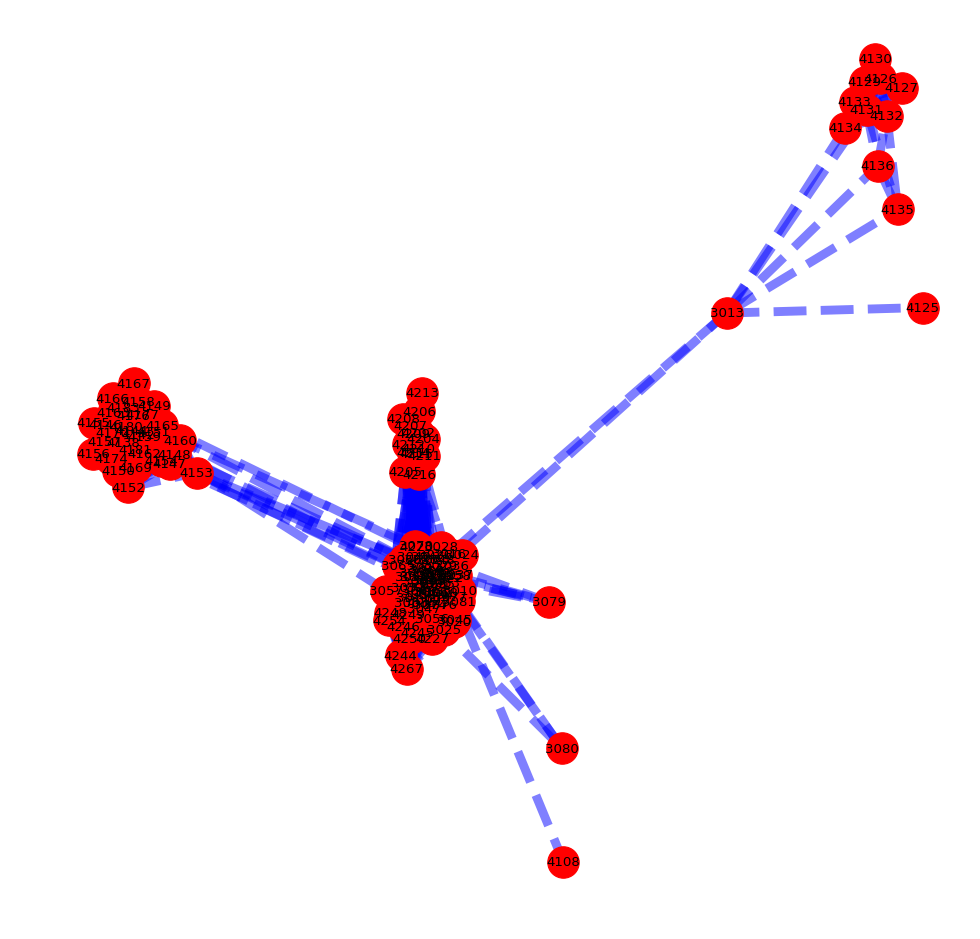

In [86]:
#bike_cleaned

# Nodes are stations
# Weights are Total number of journeys made

df = bike_cleaned[['start_station', 'end_station']].groupby(['start_station', 'end_station']).size().reset_index().rename(columns={0:'weight'})
edges = df.values.tolist()

g = nx.Graph()

plt.figure(figsize=(15,15), dpi=80)
plt.axis('off')

for i in edges:
    g.add_edge(i[0], i[1], weight=i[2])


elarge = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] > 50]
esmall = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] <= 50]

pos = nx.spring_layout(g)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(g, pos, node_size=800)

# edges
nx.draw_networkx_edges(g, pos, edgelist=elarge,
                       width=8)
nx.draw_networkx_edges(g, pos, edgelist=esmall,
                       width=8, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(g, pos, font_size=12, font_family='sans-serif')

plt.show()

From the network graph shown above, it is clear that there are 3 distinct groups of connected stations in the network. The is also another group that is not as closely connected to each other.

There are also the occasional outliers in the network that only have 1-3 connections (stations: 4108, 3080, 3079, 3013, 4125).

The shorter the dashed lines, the shorter the journey between the stations.

#### Calculate statistics of the network

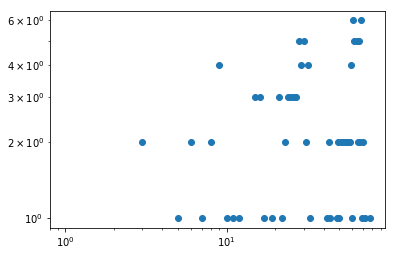

In [87]:
## Network degrees
ddist = nx.degree_histogram(g)[1:] # Skip 0 degree nodes
plt.loglog(range(1,len(ddist)+1),ddist,'o')

Showing the degree distribution, with most of the degrees around the 10^0 showing it being possibly heavy tailed

(array([ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  4.,
         3.,  2., 15., 27., 42., 18.,  8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

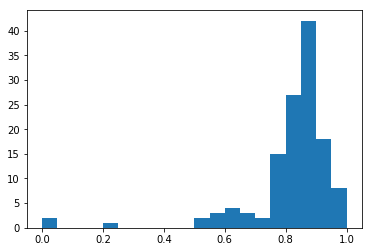

In [69]:
## Clustering coeffs
cc = nx.clustering(g)
plt.hist(list(cc.values()),bins=20)

Shows that the nodes are closely connected each other with the few outliers. 

https://github.com/gephi/gephi/wiki/Average-Clustering-Coefficient

# Task 2 – Seed shape data

### Load data and remove null values

In [88]:
seeds = pd.read_csv("seeds.csv")
seeds.shape

(210, 7)

In [89]:
#Identify null and empty values

null_columns=seeds.columns[seeds.isnull().any()]

#print(bike[null_columns].isnull().sum())
nulls = seeds[seeds.isnull().any(axis=1)][null_columns].head()
print(nulls)

Empty DataFrame
Columns: []
Index: []


In [90]:
seeds.head()

,area,perimeter,compactness,length,width,asymmetry,groove length
0,15.26,14.84,0.871,5.763,3.312,2.221,5.220
1,14.88,14.57,0.881,5.554,3.333,1.018,4.956
2,14.29,14.09,0.905,5.291,3.337,2.699,4.825
3,13.84,13.94,0.895,5.324,3.379,2.259,4.805
4,16.14,14.99,0.903,5.658,3.562,1.355,5.175


Identify and remove any null values

### Fit a Gaussian mixture model

In [91]:
mixturemodel = GaussianMixture(n_components=2)
mixturemodel.fit(seeds)

print(mixturemodel.means_)
print('\n')
print(mixturemodel.covariances_)

[[17.40948188 15.70475724  0.88457383  5.99093194  3.58968127  3.29345818
   5.77163874]
 [12.46292382 13.49311238  0.85836585  5.29122269  2.95044787  4.07878408
   5.06967299]]


[[[ 3.48896994e+00  1.55773416e+00  2.26129900e-03  5.74024446e-01
    3.58453109e-01  6.54870492e-01  7.34561939e-01]
  [ 1.55773416e+00  7.13524391e-01 -9.48561453e-04  2.71950814e-01
    1.49962557e-01  3.15849865e-01  3.48720557e-01]
  [ 2.26129900e-03 -9.48561453e-04  2.20259411e-04 -1.36565375e-03
    1.34523996e-03 -2.37376359e-03 -1.71655868e-03]
  [ 5.74024446e-01  2.71950814e-01 -1.36565375e-03  1.14976416e-01
    4.92377951e-02  1.15597085e-01  1.43805523e-01]
  [ 3.58453109e-01  1.49962557e-01  1.34523996e-03  4.92377951e-02
    4.40846332e-02  6.36616004e-02  6.29910501e-02]
  [ 6.54870492e-01  3.15849865e-01 -2.37376359e-03  1.15597085e-01
    6.36616004e-02  1.63259945e+00  1.86918990e-01]
  [ 7.34561939e-01  3.48720557e-01 -1.71655868e-03  1.43805523e-01
    6.29910501e-02  1.86918990e-01  2.

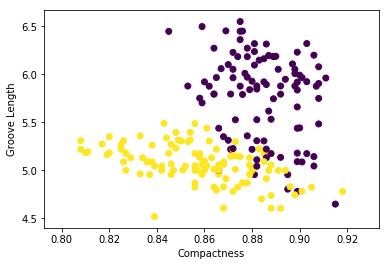

In [96]:
plt.scatter(seeds['compactness'], seeds['groove length'], c=mixturemodel.predict(seeds))
plt.ylabel('Groove Length')
plt.xlabel('Compactness');
plt.show()

This plot shows that groove length has a significate impact on how this data is clustered whereas compactness has little impact, with a cluster focusing around 5.0-5.5 with a wide range of compactness.

In [97]:
print(mixturemodel.aic(seeds))
print(mixturemodel.bic(seeds))

-1994.3271893766077
-1756.6825546956675


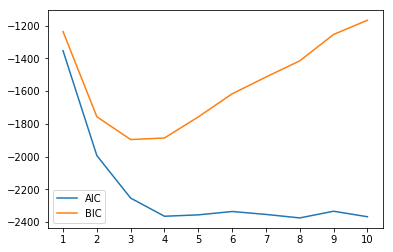

In [101]:
model_aic = []
model_bic = []
for k in range(1,11):
    mixturemodel = GaussianMixture(k)
    mixturemodel.fit(seeds)
    model_aic.append(mixturemodel.aic(seeds))
    model_bic.append(mixturemodel.bic(seeds))
    #mixturemodel.fit(seeds[['compactness', 'groove length']])
    #model_aic.append(mixturemodel.aic(seeds[['compactness','groove length']]))
    #model_bic.append(mixturemodel.bic(seeds[['compactness','groove length']]))
    
fig, ax = plt.subplots()
ax.plot(range(1, 11), model_aic, label='AIC')
ax.plot(range(1, 11), model_bic, label='BIC')
ax.legend()
ax.set_xticks(range(1, 11), minor=False)
plt.show()

This shows that both AIC and BIC perform best when the component is set to 3 or 4, with AIC performing best with 4 components and BIC at 3. As lower the score the better, therefore a guassian mixture with a component of 3 should be used based on the BIC result.

Observing when a component of 3 is used

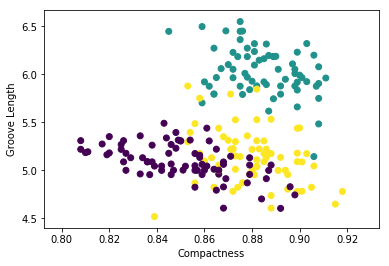

In [105]:
mixturemodel = GaussianMixture(n_components=3)
mixturemodel.fit(seeds)
plt.scatter(seeds['compactness'], seeds['groove length'], c=mixturemodel.predict(seeds))
plt.ylabel('Groove Length')
plt.xlabel('Compactness');
plt.show()

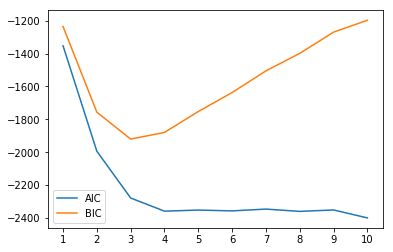

In [106]:
model_aic = []
model_bic = []
for k in range(1,11):
    mixturemodel = GaussianMixture(k)
    mixturemodel.fit(seeds)
    model_aic.append(mixturemodel.aic(seeds))
    model_bic.append(mixturemodel.bic(seeds))
    #mixturemodel.fit(seeds[['compactness', 'groove length']])
    #model_aic.append(mixturemodel.aic(seeds[['compactness','groove length']]))
    #model_bic.append(mixturemodel.bic(seeds[['compactness','groove length']]))
    
fig, ax = plt.subplots()
ax.plot(range(1, 11), model_aic, label='AIC')
ax.plot(range(1, 11), model_bic, label='BIC')
ax.legend()
ax.set_xticks(range(1, 11), minor=False)
plt.show()